This module includes heat transfer

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

from input_variables import SetupParameters
from grid import MeshGrid
from difference_equations import DiscretizationSchemes
from matrix_init import MatrixInitializer
from physics import *
from boundary_conditions import BCs
from visualization import *
from test import *

def main():
    params = SetupParameters(nx=41, ny=41, lx=2, ly=2, nt= 700, nppi=50, rho_fluid=1, nu=0.1, dt=0.001, 
                             beta = 0.0034, alpha = 1)
    X, Y, dx, dy = MeshGrid.mesh(params.nx, params.ny, params.lx, params.ly)
    
    ux_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    uy_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    
    ux_inter = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    uy_inter = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)

    ux_next = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    uy_next = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)

    p_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    p_next = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    
    if params.beta > 0:
        T_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
        T_inter = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
        T_next = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    
    for iteration in range (params.nt):
        ux_prev = ux_next.copy()
        uy_prev = uy_next.copy()
        p_prev = p_next.copy()
        T_prev = T_next.copy()
        
        dux_prev__dx = DiscretizationSchemes.backward_difference_x(ux_prev, params.dx)
        dux_prev__dy = DiscretizationSchemes.backward_difference_y(ux_prev, params.dx)
        duy_prev__dx = DiscretizationSchemes.backward_difference_x(uy_prev, params.dy)
        duy_prev__dy = DiscretizationSchemes.backward_difference_y(uy_prev, params.dy)
        
        laplace__ux_prev = DiscretizationSchemes.laplacian(ux_prev, params.dx, params.dy)
        laplace__uy_prev = DiscretizationSchemes.laplacian(uy_prev, params.dx, params.dy)
        
        if params.beta > 0: 
            dT_prev__dx = DiscretizationSchemes.central_difference_x(T_prev, params.dx)
            dT_prev__dy = DiscretizationSchemes.central_difference_y(T_prev, params.dy)
            laplace_T_prev = DiscretizationSchemes.laplacian(T_prev, params.dx, params.dy)
        
        ux_inter = HomogeneousAdvection.homogenous_advection_horizontal(ux_prev, uy_prev, dux_prev__dx, dux_prev__dy, 
                                                                       laplace__ux_prev, params.nu, params.dt)
        uy_inter = HomogeneousAdvection.homogenous_advection_vertical(ux_prev, uy_prev, duy_prev__dx, duy_prev__dy,
                                                                     laplace__uy_prev, params.nu, params.dt)
        
        ux_inter = BCs.velocity_BCx(ux_inter)
        uy_inter = BCs.velocity_BCy(uy_inter)
        
        if params.beta > 0:
            T_next = BCs.temperature_BC(T_next)
        
        dux_inter__dx = DiscretizationSchemes.backward_difference_x(ux_inter, params.dx)
        duy_inter__dy = DiscretizationSchemes.backward_difference_y(uy_inter, params.dy)
        
        b_i_j = PressurePoissonGaussSeidel.source_term_gauss_seidel(ux_inter, uy_inter,
                                                                params.dx, params.dy, params.dt)
        
        p_next = PressurePoissonGaussSeidel.pressure_poisson_gauss_seidel(p_prev, b_i_j, params.nppi,
                                                params.dx, params.dy)
        
        dp_next__dx = DiscretizationSchemes.central_difference_x(p_next, params.dx)
        dp_next__dy = DiscretizationSchemes.central_difference_y(p_next, params.dy)
        
        # Correct the velocities such that the fluid stays incompressible
        if params.beta > 0:
            T_next = HomogeneousAdvection.advection_viscous_dissipation_temperature(
                T_prev, ux_prev, uy_prev, dT_prev__dx, dT_prev__dy, laplace_T_prev, params.nu, params.dt
            )
        
        ux_next = AdvectionVelocityCorrection.velocity_correction_horizontal(ux_inter, dp_next__dx, 
                                                                 params.rho_fluid, params.dt,)
        uy_next = AdvectionVelocityCorrection.velocity_correction_vertical(uy_inter, dp_next__dy, 
        params.rho_fluid, params.dt, buoyancy=True, beta=params.beta, T_next=T_next, T_ref=T_prev, g=params.g)
                                                                        
        ux_next = BCs.velocity_BCx(ux_next)
        uy_next = BCs.velocity_BCy(uy_next)
        
        if params.beta > 0:
            T_next = BCs.temperature_BC(T_next)
            
        # params.dt = TestStability.test_CFL_number_calculation(ux_next, uy_next, params.dx, params.dy,
        #                                                params.dt, safety_factor=0.9,)
        
        # ux_prev = ux_next
        # uy_prev = uy_next
        # p_prev = p_next
        
    # # Visualize results
    # Visual.visualize_vector_plot(X, Y, ux_inter, uy_inter, streamplot=True)
    # Visual.visualize_contour_plot(X, Y, ux_prev)
    # plt.show()
        
    # fig = plt.figure(figsize=(11,7), dpi=100)
    # # plotting the pressure field as a contour
    # plt.contourf(X, Y, p_next, alpha=0.5, cmap=cm.viridis)  
    # plt.colorbar()
    # # plotting the pressure field outlines
    # plt.contour(X, Y, p_next, cmap=cm.viridis)  
    # # plotting velocity field
    # plt.quiver(X[::2, ::2], Y[::2, ::2], ux_inter[::2, ::2], uy_inter[::2, ::2]) 
    # plt.xlabel('X')
    # plt.ylabel('Y')
    
    # fig = plt.figure(figsize=(11,7), dpi = 100)
    # ax = fig.add_subplot(111, projection='3d')
    # surf = ax.plot_surface(X, Y, p_next[:], rstride=1, cstride=1, cmap=cm.viridis,
    #             linewidth=0, antialiased=False)
    # ax.view_init(30, 225)
    # ax.set_xlabel('$x$')
    # ax.set_ylabel('$y$')
    
    # fig = plt.figure(figsize=(11, 7), dpi=100)
    # plt.contourf(X, Y, p_next, alpha=0.5, cmap=cm.viridis)
    # plt.colorbar()
    # plt.contour(X, Y, p_next, cmap=cm.viridis)
    # plt.streamplot(X, Y, ux_inter, uy_inter)
    # plt.xlabel('X')
    # plt.ylabel('Y')
    
    fig = plt.figure(figsize=(11, 7), dpi=100)
    plt.contourf(X, Y, T_next, alpha=0.5, cmap=cm.viridis)
    plt.colorbar()
    plt.contour(X, Y, T_next, cmap=cm.viridis)
    plt.streamplot(X, Y, ux_next, uy_next)
    plt.xlabel('X')
    plt.ylabel('Y')
        
if __name__ == "__main__":
    main()

ValueError: could not broadcast input array from shape (40,41) into shape (41,)

## Paper Validation

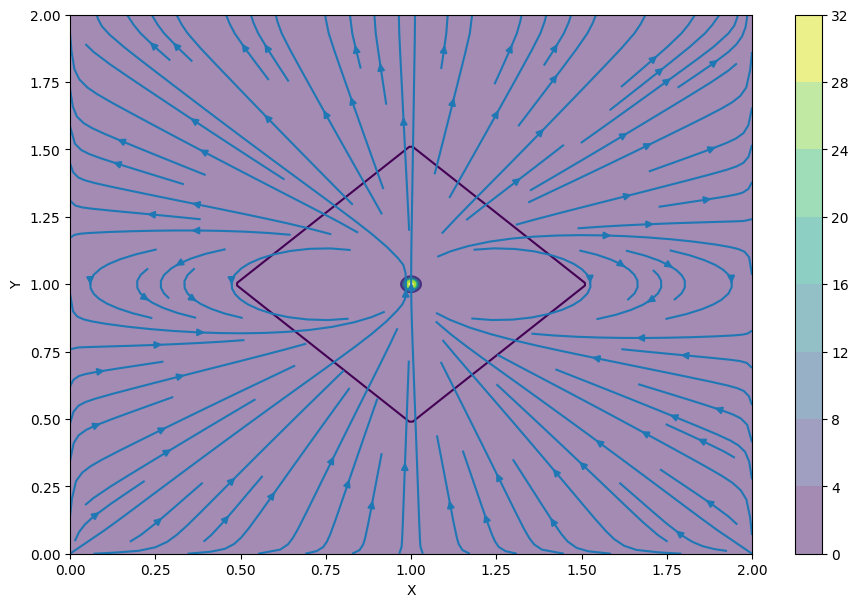

In [7]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

from input_variables import SetupParameters
from grid import MeshGrid
from difference_equations import DiscretizationSchemes
from matrix_init import MatrixInitializer
from physics import *
from boundary_conditions import BCs
from visualization import *
from test import *

def main():
    params = SetupParameters(nx=401, ny=401, lx=2, ly=2, nt= 100, nppi=50, rho_fluid=980, nu=0.001, dt=0.001, 
                             beta = 8.8e-5, alpha = 1.96, 
                             source_temp=30, source_radius=0.0125, source_ux=0, source_uy=0)
    X, Y, dx, dy = MeshGrid.mesh(params.nx, params.ny, params.lx, params.ly)
    
    ux_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    uy_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    
    ux_inter = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    uy_inter = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)

    ux_next = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    uy_next = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)

    p_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    p_next = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    
    if params.beta > 0:
        T_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
        T_inter = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
        T_next = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    
    for iteration in range (params.nt):
        ux_prev = ux_next.copy()
        uy_prev = uy_next.copy()
        p_prev = p_next.copy()
        T_prev = T_next.copy()
        
        dux_prev__dx = DiscretizationSchemes.central_difference_x(ux_prev, params.dx) # Not sure about here
        dux_prev__dy = DiscretizationSchemes.central_difference_y(ux_prev, params.dx)
        duy_prev__dx = DiscretizationSchemes.central_difference_x(uy_prev, params.dy)
        duy_prev__dy = DiscretizationSchemes.central_difference_y(uy_prev, params.dy)
        
        laplace__ux_prev = DiscretizationSchemes.laplacian(ux_prev, params.dx, params.dy)
        laplace__uy_prev = DiscretizationSchemes.laplacian(uy_prev, params.dx, params.dy)
        
        if params.beta > 0: 
            dT_prev__dx = DiscretizationSchemes.central_difference_x(T_prev, params.dx)
            dT_prev__dy = DiscretizationSchemes.central_difference_y(T_prev, params.dy)
            laplace_T_prev = DiscretizationSchemes.laplacian(T_prev, params.dx, params.dy)
            
        ux_prev = BCs.velocity_BCx(ux_prev)
        uy_prev = BCs.velocity_BCy(uy_prev)
        ux_prev = SourceBC.source_ux_BC(ux_prev, params.source_ux, params.source_radius, params.lx,
                                        params.ly, params.nx, params.ny)
        uy_prev = SourceBC.source_uy_BC(uy_prev, params.source_uy, params.source_radius, params.lx,
                                        params.ly, params.nx, params.ny)    

        ux_inter = HomogeneousAdvection.homogenous_advection_horizontal(ux_prev, uy_prev, dux_prev__dx, dux_prev__dy, 
                                                                       laplace__ux_prev, params.nu, params.dt)
        uy_inter = HomogeneousAdvection.homogenous_advection_vertical(ux_prev, uy_prev, duy_prev__dx, duy_prev__dy,
                                                                     laplace__uy_prev, params.nu, params.dt)
        
        ux_inter = BCs.velocity_BCx(ux_inter)
        uy_inter = BCs.velocity_BCy(uy_inter)
        ux_inter = SourceBC.source_ux_BC(ux_inter, params.source_ux, params.source_radius, params.lx,
                                        params.ly, params.nx, params.ny)
        uy_inter = SourceBC.source_uy_BC(uy_inter, params.source_uy, params.source_radius, params.lx,
                                        params.ly, params.nx, params.ny)
        
        if params.beta > 0:
            T_next = BCs.temperature_BC(T_next)
            T_next = SourceBC.source_temp_BC(T_next, params.source_temp, params.source_radius, params.lx, 
                                             params.ly, params.nx, params.ny)
        
        dux_inter__dx = DiscretizationSchemes.backward_difference_x(ux_inter, params.dx)
        duy_inter__dy = DiscretizationSchemes.backward_difference_y(uy_inter, params.dy)
        
        b_i_j = PressurePoissonGaussSeidel.source_term_gauss_seidel(ux_inter, uy_inter,
                                                                params.dx, params.dy, params.dt)
        
        p_next = PressurePoissonGaussSeidel.pressure_poisson_gauss_seidel(p_prev, b_i_j, params.nppi,
                                                params.dx, params.dy)
        
        dp_next__dx = DiscretizationSchemes.central_difference_x(p_next, params.dx)
        dp_next__dy = DiscretizationSchemes.central_difference_y(p_next, params.dy)
        
        # Correct the velocities such that the fluid stays incompressible
        if params.beta > 0:
            T_next = HomogeneousAdvection.advection_viscous_dissipation_temperature(
                T_prev, ux_prev, uy_prev, dT_prev__dx, dT_prev__dy, laplace_T_prev, params.nu, params.dt
            )
        
        ux_next = AdvectionVelocityCorrection.velocity_correction_horizontal(ux_inter, dp_next__dx, 
                                                                 params.rho_fluid, params.dt,)
        uy_next = AdvectionVelocityCorrection.velocity_correction_vertical(uy_inter, dp_next__dy, 
        params.rho_fluid, params.dt, buoyancy=True, beta=params.beta, T_next=T_next, T_ref=T_prev, g=params.g)
                                                                        
        ux_next = BCs.velocity_BCx(ux_next)
        uy_next = BCs.velocity_BCy(uy_next)
        ux_next = SourceBC.source_ux_BC(ux_next, params.source_ux, params.source_radius, params.lx,
                                        params.ly, params.nx, params.ny)
        uy_next = SourceBC.source_uy_BC(uy_next, params.source_uy, params.source_radius, params.lx,
                                        params.ly, params.nx, params.ny)
        
        if params.beta > 0:
            T_next = BCs.temperature_BC(T_next)
            T_next = SourceBC.source_temp_BC(T_next, params.source_temp, params.source_radius, params.lx, 
                                             params.ly, params.nx, params.ny)
            
        # params.dt = TestStability.test_CFL_number_calculation(ux_next, uy_next, params.dx, params.dy,
        #                                                params.dt, safety_factor=0.9,)
        
        # ux_prev = ux_next
        # uy_prev = uy_next
        # p_prev = p_next
        
    # # Visualize results
    # Visual.visualize_vector_plot(X, Y, ux_inter, uy_inter, streamplot=True)
    # Visual.visualize_contour_plot(X, Y, ux_prev)
    # plt.show()
        
    # fig = plt.figure(figsize=(11,7), dpi=100)
    # # plotting the pressure field as a contour
    # plt.contourf(X, Y, p_next, alpha=0.5, cmap=cm.viridis)  
    # plt.colorbar()
    # # plotting the pressure field outlines
    # plt.contour(X, Y, p_next, cmap=cm.viridis)  
    # # plotting velocity field
    # plt.quiver(X[::2, ::2], Y[::2, ::2], ux_inter[::2, ::2], uy_inter[::2, ::2]) 
    # plt.xlabel('X')
    # plt.ylabel('Y')
    
    # fig = plt.figure(figsize=(11,7), dpi = 100)
    # ax = fig.add_subplot(111, projection='3d')
    # surf = ax.plot_surface(X, Y, p_next[:], rstride=1, cstride=1, cmap=cm.viridis,
    #             linewidth=0, antialiased=False)
    # ax.view_init(30, 225)
    # ax.set_xlabel('$x$')
    # ax.set_ylabel('$y$')
    
    # fig = plt.figure(figsize=(11, 7), dpi=100)
    # plt.contourf(X, Y, p_next, alpha=0.5, cmap=cm.viridis)
    # plt.colorbar()
    # plt.contour(X, Y, p_next, cmap=cm.viridis)
    # plt.streamplot(X, Y, ux_inter, uy_inter)
    # plt.xlabel('X')
    # plt.ylabel('Y')
    
    fig = plt.figure(figsize=(11, 7), dpi=100)
    plt.contourf(X, Y, T_next, alpha=0.5, cmap=cm.viridis)
    plt.colorbar()
    plt.contour(X, Y, T_next, cmap=cm.viridis)
    plt.streamplot(X, Y, ux_next, uy_next)
    plt.xlabel('X')
    plt.ylabel('Y')
        
if __name__ == "__main__":
    main()

C:\Users\saeed\AppData\Local\Temp\ipykernel_23336\510934705.py:99: RuntimeWarning: divide by zero encountered in scalar divide
  Spin_up.append((np.mean(ux_next) - np.mean(ux_prev))/np.mean(ux_prev))


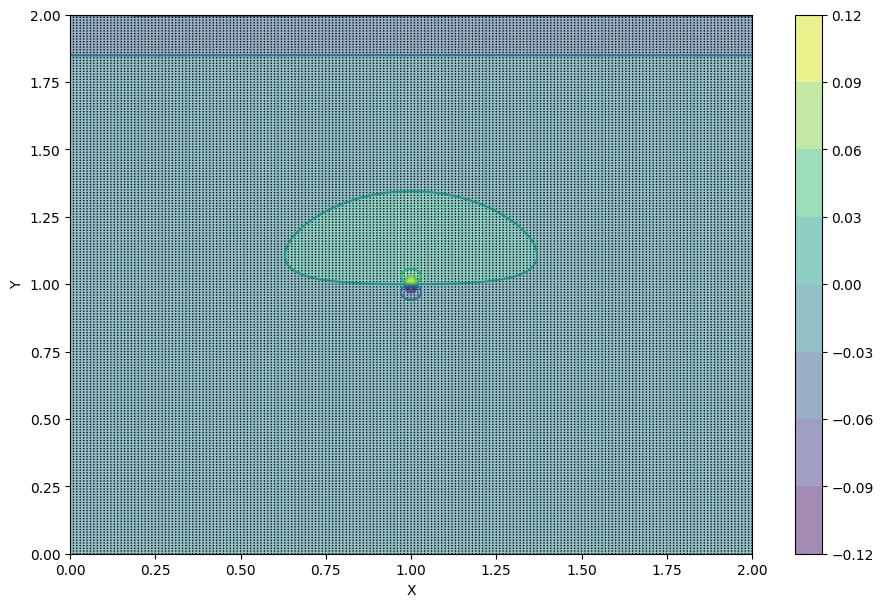

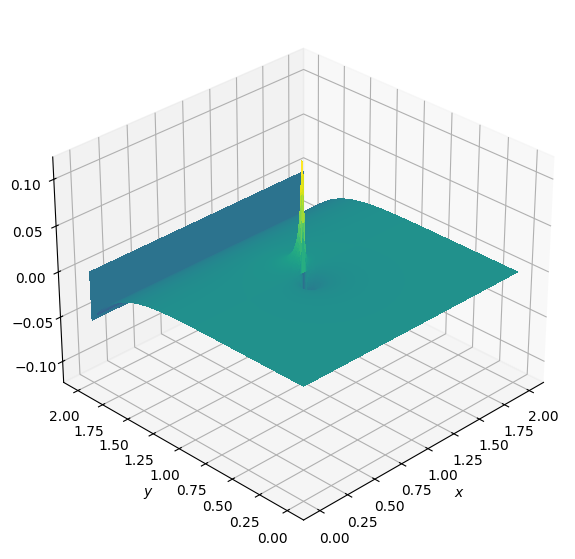

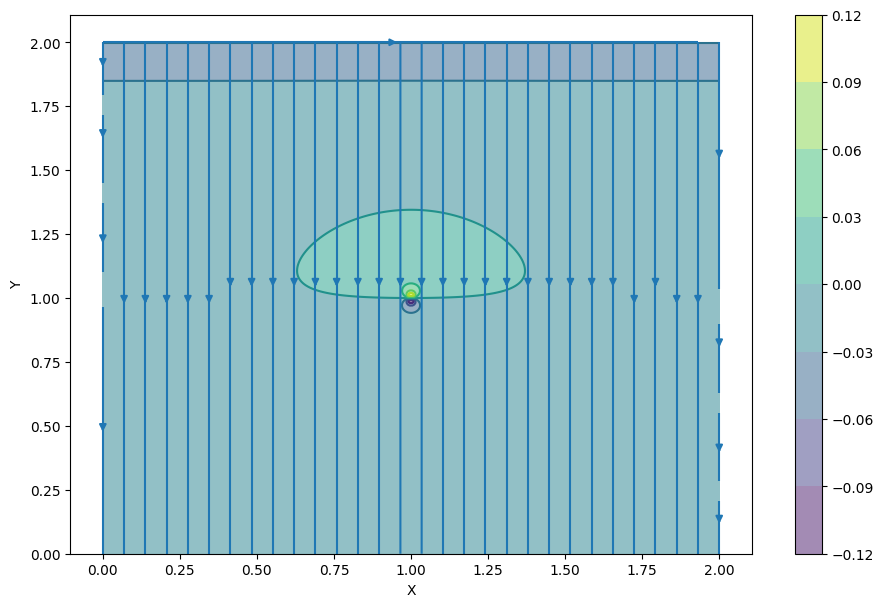

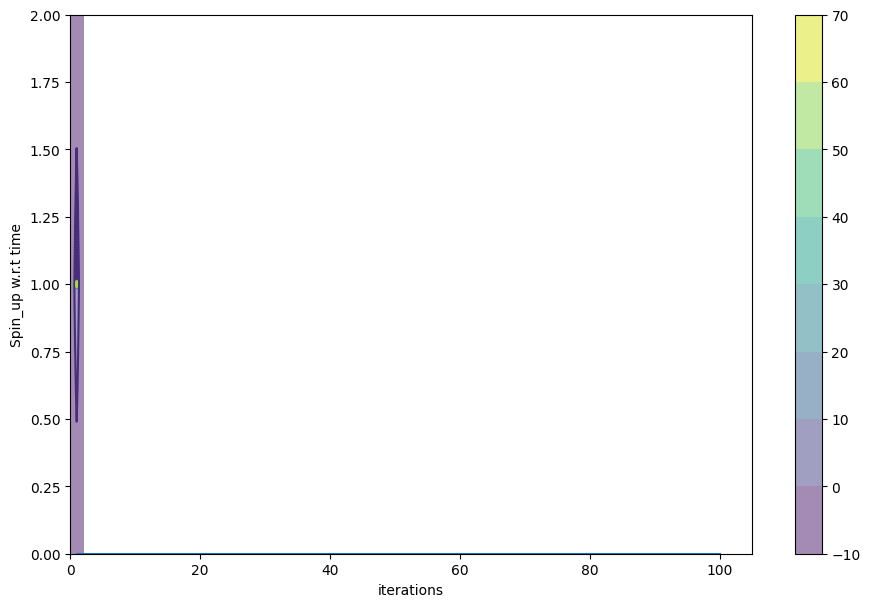

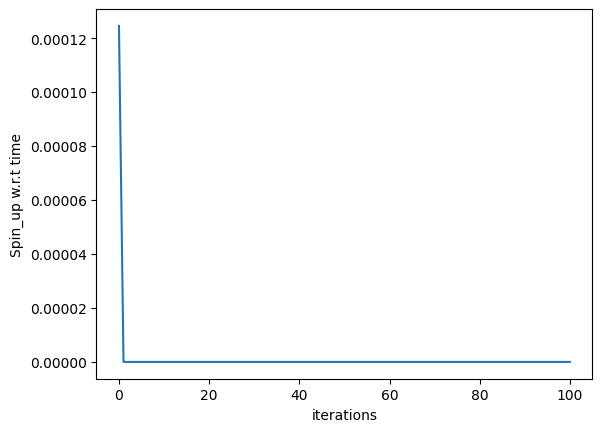

In [19]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

from input_variables import SetupParameters
from grid import MeshGrid
from difference_equations import DiscretizationSchemes
from matrix_init import MatrixInitializer
from physics import *
from boundary_conditions import *
from visualization import *
from test import *

def main():
    params = SetupParameters(nx=401, ny=401, lx=2, ly=2, nt= 100, nppi=150, rho_fluid=1000, nu=0.001, 
                             beta = 8.8e-5, alpha = 1.96e-6, k = 1e-08, n=0.45, g=9.81, c_p_f = 4290,
                             source_temp=70, source_radius=0.0125, source_ux=0, source_uy=0, lambda_f=0.6)
    
    dt = 0.001
    X, Y, dx, dy = MeshGrid.mesh(params.nx, params.ny, params.lx, params.ly)
    
    ux_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    uy_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    
    ux_next = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    uy_next = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)

    p_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    p_next = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    
    T_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    T_next = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    
    Spin_up = []
    Error = []
    
    for iteration in range (params.nt):
        dt = 0.001
        ux_prev = ux_next.copy()
        uy_prev = uy_next.copy()
        p_prev = p_next.copy()
        T_prev = T_next.copy()

        dT_prev__dx = DiscretizationSchemes.central_difference_x(T_prev, params.dx)
        dT_prev__dy = DiscretizationSchemes.central_difference_y(T_prev, params.dy)
        laplace_T_prev = DiscretizationSchemes.laplacian(T_prev, params.dx, params.dy)
            
        # ux_prev = BCs.velocity_BCx(ux_prev)
        # uy_prev = BCs.velocity_BCy(uy_prev)
        # ux_prev = SourceBC.source_ux_BC(ux_prev, params.source_ux, params.source_radius, params.lx,
        #                                 params.ly, params.nx, params.ny)
        # uy_prev = SourceBC.source_uy_BC(uy_prev, params.source_uy, params.source_radius, params.lx,
        #                                 params.ly, params.nx, params.ny)    

        b_i_j = PressurePoissonGaussSeidel.source_term_gauss_seidel(ux_prev, uy_prev, params.dx, params.dy, dt=dt)
        
        p_next = PressurePoissonGaussSeidel.pressure_poisson_gauss_seidel(p_prev, b_i_j, params.nppi, params.dx, params.dy)
        
        dp_next__dx = DiscretizationSchemes.central_difference_x(p_next, params.dx)
        dp_next__dy = DiscretizationSchemes.central_difference_y(p_next, params.dy)
        
        # Correct the velocities such that the fluid stays incompressible
        T_next = DarcyVelocity.advection_diffusion_temperature(
            T_prev, ux_prev, uy_prev, dT_prev__dx, dT_prev__dy, laplace_T_prev, 
            params.rho_fluid, params.c_p_f, params.lambda_b, params.alpha, params.dx, params.dy, dt=dt
            )
        
        ux_next = DarcyVelocity.darcy_velocity_x(
            T_next, T_prev, dp_next__dx, ux_prev, params.rho_fluid, params.beta, 
            params.k, params.n, params.nu, dt=dt
            )

        uy_next = DarcyVelocity.darcy_velocity_y(
            T_next, T_prev, dp_next__dy, uy_prev, params.rho_fluid, params.beta, 
            params.k, params.n, params.nu, params.g, dt=dt
            )
                                                                        
        ux_next = BCs.velocity_BCx(ux_next)
        uy_next = BCs.velocity_BCy(uy_next)
        ux_next = SourceBC.source_ux_BC(
            ux_next, params.source_ux, params.source_radius, params.lx, params.ly, params.nx, params.ny
            )
        uy_next = SourceBC.source_uy_BC(
            uy_next, params.source_uy, params.source_radius, params.lx, params.ly, params.nx, params.ny
            )
        
        T_next = BCs.temperature_BC(T_next)
        T_next = SourceBC.source_temp_BC(
            T_next, params.source_temp, params.source_radius, params.lx, params.ly, params.nx, params.ny
            )
            
        dt = TestStability.test_CFL_number_calculation(
            ux_next, uy_next, params.dx, params.dy,
                                                        dt=dt, safety_factor=0.9)
        
        # Error Handelling
        Spin_up.append((np.mean(ux_next) - np.mean(ux_prev))/np.mean(ux_prev))
        Error.append((np.sqrt(np.sum((ux_next - ux_prev)**2))/ (params.nx * params.ny)))
        
        # ux_prev = ux_next
        # uy_prev = uy_next
        # p_prev = p_next
        
    # Visualize results    
    fig = plt.figure(figsize=(11,7), dpi=100)
    # plotting the pressure field as a contour
    plt.contourf(X, Y, p_next, alpha=0.5, cmap=cm.viridis)  
    plt.colorbar()
    # plotting the pressure field outlines
    plt.contour(X, Y, p_next, cmap=cm.viridis)  
    # plotting velocity field
    plt.quiver(X[::2, ::2], Y[::2, ::2], ux_next[::2, ::2], uy_next[::2, ::2]) 
    plt.xlabel('X')
    plt.ylabel('Y')
    
    fig = plt.figure(figsize=(11,7), dpi = 100)
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, p_next[:], rstride=1, cstride=1, cmap=cm.viridis,
                linewidth=0, antialiased=False)
    ax.view_init(30, 225)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    
    fig = plt.figure(figsize=(11, 7), dpi=100)
    plt.contourf(X, Y, p_next, alpha=0.5, cmap=cm.viridis)
    plt.colorbar()
    plt.contour(X, Y, p_next, cmap=cm.viridis)
    plt.streamplot(X, Y, ux_next, uy_next)
    plt.xlabel('X')
    plt.ylabel('Y')
    
    fig = plt.figure(figsize=(11, 7), dpi=100)
    plt.contourf(X, Y, T_next, alpha=0.5, cmap=cm.viridis)
    plt.colorbar()
    plt.contour(X, Y, T_next, cmap=cm.viridis)
    # plt.streamplot(X, Y, ux_next, uy_next)
    plt.xlabel('X')
    plt.ylabel('Y')
    
    Spin_up = np.array(Spin_up)
    np.shape(Spin_up)
        
    #plt.ylabel('Error')
    #plt.xlabel('Timesteps')
    plt.plot(np.linspace(0,params.nt,params.nt),Spin_up)
    plt.xlim()
    plt.ylim()
    plt.ylabel('Spin_up w.r.t time')
    plt.xlabel('iterations')
    plt.show()
    
    Error = np.array(Error)
    np.shape(Error)
        
    #plt.ylabel('Error')
    #plt.xlabel('Timesteps')
    plt.plot(np.linspace(0,params.nt,params.nt),Error)
    plt.xlim()
    plt.ylim()
    plt.ylabel('Spin_up w.r.t time')
    plt.xlabel('iterations')
    plt.show()
    
    # print (ux_next)
        
if __name__ == "__main__":
    main()

C:\Users\saeed\AppData\Local\Temp\ipykernel_23216\2739988278.py:119: RuntimeWarning: invalid value encountered in scalar divide
  Spin_up.append((np.mean(ux_next) - np.mean(ux_prev))/np.mean(ux_prev))
C:\Users\saeed\AppData\Local\Temp\ipykernel_23216\2739988278.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  Spin_up.append((np.mean(ux_next) - np.mean(ux_prev))/np.mean(ux_prev))


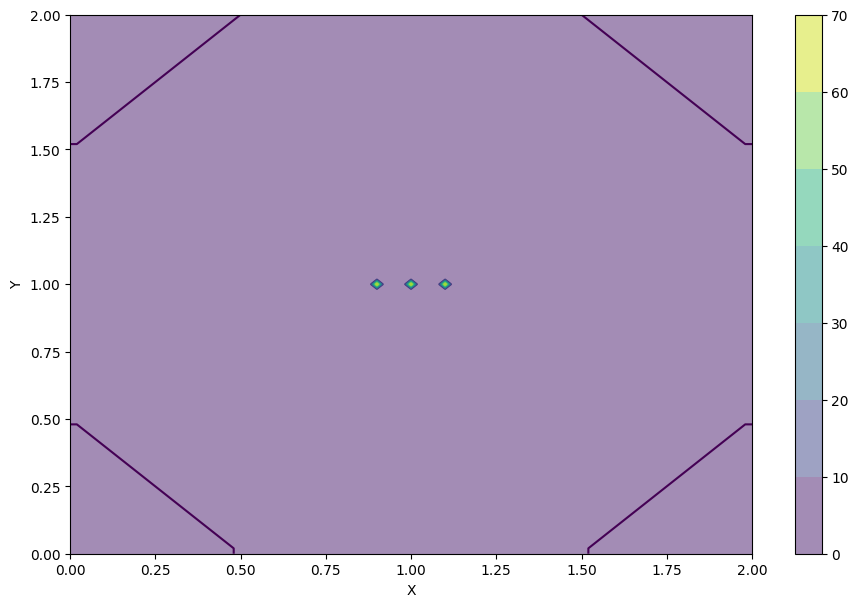

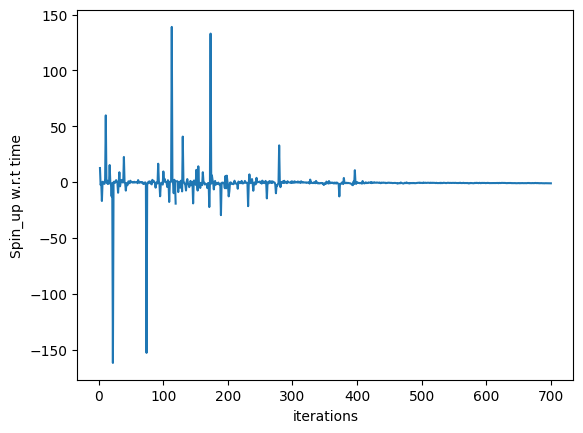

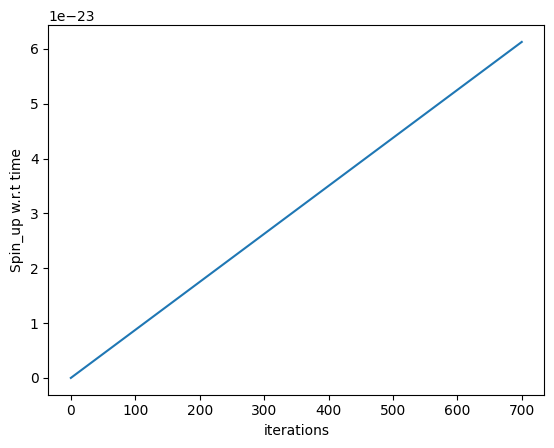

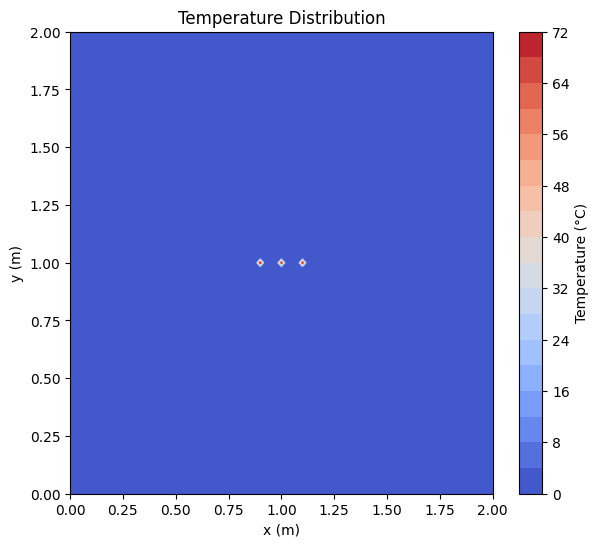

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

from input_variables import SetupParameters
from grid import MeshGrid
from difference_equations import DiscretizationSchemes
from matrix_init import MatrixInitializer
from physics import *
from boundary_conditions import *
from visualization import *
from test import *

def main():
    params = SetupParameters(
                            nx=101, ny=101, lx=2, ly=2, nt= 700, nppi=500, rho_fluid=1000, nu=0.0001, 
                             beta = 8.8e-5, alpha = 1.96e-6, k = 1e-15, n=0.45, g=9.81, c_p_f = 4290,
                             source_temp=70, source_radius=0.0125, source_ux=0, source_uy=0, 
                             lambda_f=0.6, lambda_s=1
                             )
    
    dt = 0.001
    X, Y, dx, dy = MeshGrid.mesh(params.nx, params.ny, params.lx, params.ly)
    
    ux_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=False, 
                                                      initial_value=1e-12)
    uy_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=False, 
                                                      initial_value=1e-12)
    
    ux_next = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    uy_next = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)

    p_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    p_next = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    
    T_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    T_next = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    T_ref = MatrixInitializer.matrix_initialization(params.nx, params.ny, zero_initialization=True)
    
    Spin_up = []
    Error = []
    
    for iteration in range (params.nt):
        dt = 0.001
        ux_prev = ux_next.copy()
        uy_prev = uy_next.copy()
        p_prev = p_next.copy()
        T_prev = T_next.copy()

        dT_prev__dx = DiscretizationSchemes.central_difference_x(T_prev, params.dx)
        dT_prev__dy = DiscretizationSchemes.central_difference_y(T_prev, params.dy)
        laplace_T_prev = DiscretizationSchemes.laplacian(T_prev, params.dx, params.dy)

        b_i_j = PressurePoissonGaussSeidel.source_term_gauss_seidel(
            ux_prev, uy_prev, params.dx, params.dy, dt=dt
            )
        
        p_next = PressurePoissonGaussSeidel.pressure_poisson_gauss_seidel(
            p_prev, b_i_j, params.nppi, params.dx, params.dy
            )
        
        dp_next__dx = DiscretizationSchemes.central_difference_x(p_next, params.dx)
        dp_next__dy = DiscretizationSchemes.central_difference_y(p_next, params.dy)
        
        # Correct the velocities such that the fluid stays incompressible
        # T_next = DarcyVelocity.advection_diffusion_temperature(
        #     T_prev, ux_prev, uy_prev, dT_prev__dx, dT_prev__dy, laplace_T_prev, 
        #     params.rho_fluid, params.c_p_f, params.lambda_b, params.alpha, params.dx, params.dy, dt=dt
        #     )
        
        T_next = DarcyVelocity.implicit_advection_diffusion_temperature(
        T_prev, ux_prev, uy_prev, params.rho_fluid, params.c_p_f, params.lambda_b,
        params.alpha, params.dx, params.dy, dt
            )
        
        ux_next = DarcyVelocity.darcy_velocity_upwind_x(
            T_next, T_prev, dp_next__dx, ux_prev, uy_prev, params.rho_fluid, params.beta, 
            params.k, params.n, params.nu, params.dx, dt=dt
            )

        uy_next = DarcyVelocity.darcy_velocity_upwind_y(
            T_next, T_ref, dp_next__dy, ux_prev, uy_prev, params.rho_fluid, params.beta, 
            params.k, params.n, params.nu, params.g, params.dy, dt=dt
            )
                                                                        
        ux_next = BCs.velocity_BCx(ux_next)
        uy_next = BCs.velocity_BCy(uy_next)
        ux_next = SourceBC.source_ux_BC(
            ux_next, params.source_ux, params.source_radius, params.lx, params.ly, params.nx, params.ny
            )
        uy_next = SourceBC.source_uy_BC(
            uy_next, params.source_uy, params.source_radius, params.lx, params.ly, params.nx, params.ny
            )
        
        T_next = BCs.temperature_BC(T_next)
        T_next = SourceBC.source_temp_BC(
            T_next, params.source_temp, params.source_radius, params.lx, params.ly, params.nx, params.ny
            )
        
        ## 
        ux_prev = SourceBC.source_ux_BC_2(ux_prev, params.source_ux, params.source_radius, params.lx,
                                        params.ly, params.nx, params.ny)
        uy_prev = SourceBC.source_uy_BC_2(uy_prev, params.source_uy, params.source_radius, params.lx,
                                        params.ly, params.nx, params.ny)    
        T_next = SourceBC.source_temp_BC_2(
            T_next, params.source_temp, params.source_radius, params.lx, params.ly, params.nx, params.ny
            )
        
        ux_prev = SourceBC.source_ux_BC_3(ux_prev, params.source_ux, params.source_radius, params.lx,
                                        params.ly, params.nx, params.ny)
        uy_prev = SourceBC.source_uy_BC_3(uy_prev, params.source_uy, params.source_radius, params.lx,
                                        params.ly, params.nx, params.ny)    
        T_next = SourceBC.source_temp_BC_3(
            T_next, params.source_temp, params.source_radius, params.lx, params.ly, params.nx, params.ny
            )
        ##
            
        # dt = TestStability.test_CFL_number_calculation(
        #     ux_next, uy_next, params.dx, params.dy, dt=dt, safety_factor=0.9)
        
        # Error Handelling
        Spin_up.append((np.mean(ux_next) - np.mean(ux_prev))/np.mean(ux_prev))
        Error.append((np.sqrt(np.sum((ux_next - ux_prev)**2))/ (params.nx * params.ny)))

    # # Visualize results    
    # fig = plt.figure(figsize=(11,7), dpi=100)
    # # plotting the pressure field as a contour
    # plt.contourf(X, Y, p_next, alpha=0.5, cmap=cm.viridis)  
    # plt.colorbar()
    # # plotting the pressure field outlines
    # plt.contour(X, Y, p_next, cmap=cm.viridis)  
    # # plotting velocity field
    # plt.quiver(X[::2, ::2], Y[::2, ::2], ux_next[::2, ::2], uy_next[::2, ::2]) 
    # plt.xlabel('X')
    # plt.ylabel('Y')
    
    # fig = plt.figure(figsize=(11,7), dpi = 100)
    # ax = fig.add_subplot(111, projection='3d')
    # surf = ax.plot_surface(X, Y, p_next[:], rstride=1, cstride=1, cmap=cm.viridis,
    #             linewidth=0, antialiased=False)
    # ax.view_init(30, 225)
    # ax.set_xlabel('$x$')
    # ax.set_ylabel('$y$')
    
    # fig = plt.figure(figsize=(11, 7), dpi=100)
    # plt.contourf(X, Y, p_next, alpha=0.5, cmap=cm.viridis)
    # plt.colorbar()
    # plt.contour(X, Y, p_next, cmap=cm.viridis)
    # plt.streamplot(X, Y, ux_next, uy_next)
    # plt.xlabel('X')
    # plt.ylabel('Y')
    
    fig = plt.figure(figsize=(11, 7), dpi=100)
    plt.contourf(X, Y, T_next, alpha=0.5, cmap=cm.viridis)
    plt.colorbar()
    plt.contour(X, Y, T_next, cmap=cm.viridis)
    # plt.streamplot(X, Y, ux_next, uy_next)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    
    Spin_up = np.array(Spin_up)
    np.shape(Spin_up)
        
    #plt.ylabel('Error')
    #plt.xlabel('Timesteps')
    plt.plot(np.linspace(0,params.nt,params.nt),Spin_up)
    plt.xlim()
    plt.ylim()
    plt.ylabel('Spin_up w.r.t time')
    plt.xlabel('iterations')
    plt.show()
    
    Error = np.array(Error)
    np.shape(Error)
        
    #plt.ylabel('Error')
    #plt.xlabel('Timesteps')
    plt.plot(np.linspace(0,params.nt,params.nt),Error)
    plt.xlim()
    plt.ylim()
    plt.ylabel('Spin_up w.r.t time')
    plt.xlabel('iterations')
    plt.show()
    
    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    cf = plt.contourf(X, Y, T_next, levels=20, cmap='coolwarm')
    plt.colorbar(cf, label='Temperature (°C)')
    title = 'Temperature Distribution'
    plt.title(title)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.show
    
    # print (ux_next)
        
if __name__ == "__main__":
    main()

Simulation Progress:   0%|          | 0/700 [00:00<?, ?it/s]C:\Users\saeed\AppData\Local\Temp\ipykernel_21804\27217473.py:84: RuntimeWarning: invalid value encountered in scalar divide
  spin_up.append((np.mean(ux_next) - np.mean(ux_prev)) / np.mean(ux_prev))
Simulation Progress:   0%|          | 1/700 [00:00<01:34,  7.40it/s]C:\Users\saeed\AppData\Local\Temp\ipykernel_21804\27217473.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  spin_up.append((np.mean(ux_next) - np.mean(ux_prev)) / np.mean(ux_prev))
Simulation Progress: 100%|██████████| 700/700 [01:16<00:00,  9.16it/s]


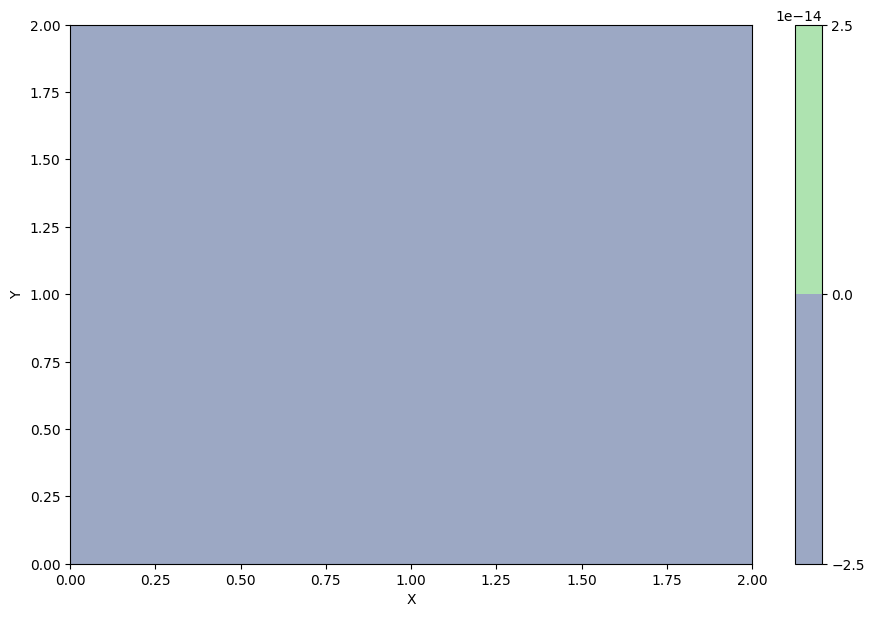

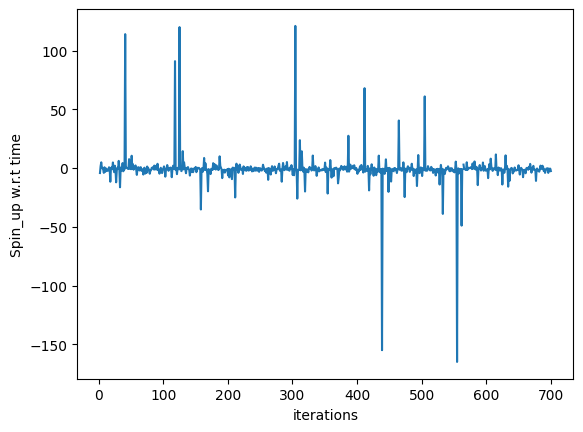

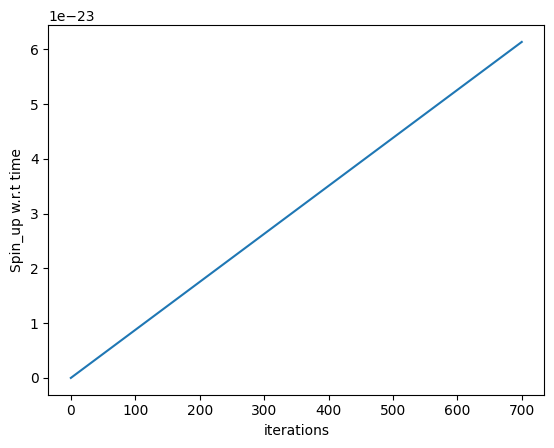

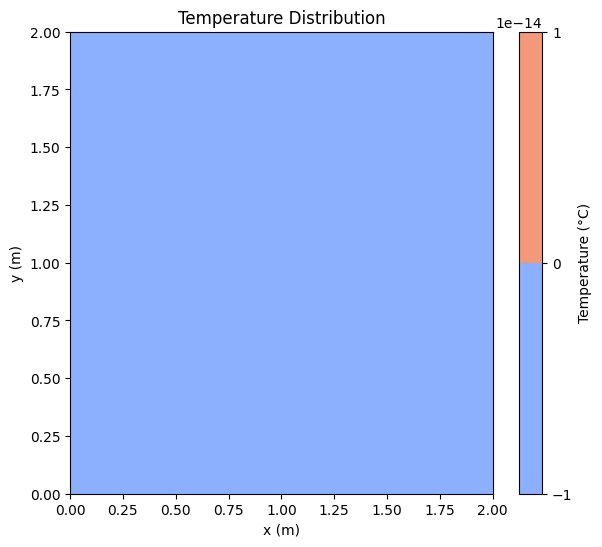

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

from input_variables import SetupParameters
from grid import MeshGrid
from difference_equations import DiscretizationSchemes
from matrix_init import MatrixInitializer
from physics import DarcyVelocity, PressurePoissonGaussSeidel
from boundary_conditions import BCs, SourceBC
# from visualization import Visualizer

def main():
    # Setup parameters
    params = SetupParameters(
        nx=101, ny=101, lx=2, ly=2, nt=700, nppi=500, rho_fluid=1000, nu=0.0001,
        beta=8.8e-5, alpha=1.96e-6, k=1e-15, n=0.45, g=9.81, c_p_f=4290,
        source_temp=70, source_radius=0.0125, source_ux=0, source_uy=0,
        lambda_f=0.6, lambda_s=1
    )

    # Initialize grid and variables
    X, Y, dx, dy = MeshGrid.mesh(params.nx, params.ny, params.lx, params.ly)
    dt = 0.001

    ux_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, initial_value=1e-12)
    uy_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny, initial_value=1e-12)
    p_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny)
    T_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny)
    T_ref = MatrixInitializer.matrix_initialization(params.nx, params.ny)

    spin_up = []
    error = []

    # Main simulation loop
    for iteration in tqdm(range(params.nt), desc="Simulation Progress"):
        # Copy previous values
        ux_next, uy_next, p_next, T_next = ux_prev.copy(), uy_prev.copy(), p_prev.copy(), T_prev.copy()

        # Calculate derivatives
        dT_prev__dx = DiscretizationSchemes.central_difference_x(T_prev, dx)
        dT_prev__dy = DiscretizationSchemes.central_difference_y(T_prev, dy)
        laplace_T_prev = DiscretizationSchemes.laplacian(T_prev, dx, dy)

        # Apply boundary conditions
        ux_prev, uy_prev = BCs.velocity_BCx(ux_prev), BCs.velocity_BCy(uy_prev)
        T_next = BCs.temperature_BC(T_next)

        # Apply source boundary conditions
        ux_prev = SourceBC.source_ux_BC(ux_prev, params.source_ux, params.source_radius, params.lx, params.ly, params.nx, params.ny)
        uy_prev = SourceBC.source_uy_BC(uy_prev, params.source_uy, params.source_radius, params.lx, params.ly, params.nx, params.ny)
        T_next = SourceBC.source_temp_BC(T_next, params.source_temp, params.source_radius, params.lx, params.ly, params.nx, params.ny)

        # Solve pressure Poisson equation
        b_i_j = PressurePoissonGaussSeidel.source_term_gauss_seidel(ux_prev, uy_prev, dx, dy, dt)
        p_next = PressurePoissonGaussSeidel.pressure_poisson_gauss_seidel(p_prev, b_i_j, params.nppi, dx, dy)

        # Calculate pressure gradients
        dp_next__dx = DiscretizationSchemes.central_difference_x(p_next, dx)
        dp_next__dy = DiscretizationSchemes.central_difference_y(p_next, dy)

        # Update temperature and velocities
        T_next = DarcyVelocity.advection_diffusion_temperature(
            T_prev, ux_prev, uy_prev, dT_prev__dx, dT_prev__dy, laplace_T_prev,
            params.rho_fluid, params.c_p_f, params.lambda_b, params.alpha, dx, dy, dt
        )

        ux_next = DarcyVelocity.darcy_velocity_x(
            T_next, T_prev, dp_next__dx, ux_prev, params.rho_fluid, params.beta,
            params.k, params.n, params.nu, dt
        )

        uy_next = DarcyVelocity.darcy_velocity_y(
            T_next, T_ref, dp_next__dy, uy_prev, params.rho_fluid, params.beta,
            params.k, params.n, params.nu, params.g, dt
        )

        # Apply boundary conditions again
        ux_next, uy_next = BCs.velocity_BCx(ux_next), BCs.velocity_BCy(uy_next)
        T_next = BCs.temperature_BC(T_next)

        # Calculate errors and update variables for next iteration
        spin_up.append((np.mean(ux_next) - np.mean(ux_prev)) / np.mean(ux_prev))
        error.append(np.sqrt(np.sum((ux_next - ux_prev)**2)) / (params.nx * params.ny))
        ux_prev, uy_prev, p_prev, T_prev = ux_next, uy_next, p_next, T_next

    # # Visualize results
    # Visualizer.plot_temperature(X, Y, T_next)
    # Visualizer.plot_spin_up(params.nt, np.array(spin_up))
    # Visualizer.plot_error(params.nt, np.array(error))
    
        # # Visualize results    
    # fig = plt.figure(figsize=(11,7), dpi=100)
    # # plotting the pressure field as a contour
    # plt.contourf(X, Y, p_next, alpha=0.5, cmap=cm.viridis)  
    # plt.colorbar()
    # # plotting the pressure field outlines
    # plt.contour(X, Y, p_next, cmap=cm.viridis)  
    # # plotting velocity field
    # plt.quiver(X[::2, ::2], Y[::2, ::2], ux_next[::2, ::2], uy_next[::2, ::2]) 
    # plt.xlabel('X')
    # plt.ylabel('Y')
    
    # fig = plt.figure(figsize=(11,7), dpi = 100)
    # ax = fig.add_subplot(111, projection='3d')
    # surf = ax.plot_surface(X, Y, p_next[:], rstride=1, cstride=1, cmap=cm.viridis,
    #             linewidth=0, antialiased=False)
    # ax.view_init(30, 225)
    # ax.set_xlabel('$x$')
    # ax.set_ylabel('$y$')
    
    # fig = plt.figure(figsize=(11, 7), dpi=100)
    # plt.contourf(X, Y, p_next, alpha=0.5, cmap=cm.viridis)
    # plt.colorbar()
    # plt.contour(X, Y, p_next, cmap=cm.viridis)
    # plt.streamplot(X, Y, ux_next, uy_next)
    # plt.xlabel('X')
    # plt.ylabel('Y')
    
    fig = plt.figure(figsize=(11, 7), dpi=100)
    plt.contourf(X, Y, T_next, alpha=0.5, cmap=cm.viridis)
    plt.colorbar()
    plt.contour(X, Y, T_next, cmap=cm.viridis)
    # plt.streamplot(X, Y, ux_next, uy_next)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    
    spin_up = np.array(spin_up)
    np.shape(spin_up)
        
    #plt.ylabel('Error')
    #plt.xlabel('Timesteps')
    plt.plot(np.linspace(0,params.nt,params.nt),spin_up)
    plt.xlim()
    plt.ylim()
    plt.ylabel('Spin_up w.r.t time')
    plt.xlabel('iterations')
    plt.show()
    
    Error = np.array(error)
    np.shape(error)
        
    #plt.ylabel('Error')
    #plt.xlabel('Timesteps')
    plt.plot(np.linspace(0,params.nt,params.nt),error)
    plt.xlim()
    plt.ylim()
    plt.ylabel('Spin_up w.r.t time')
    plt.xlabel('iterations')
    plt.show()
    
    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    cf = plt.contourf(X, Y, T_next, levels=20, cmap='coolwarm')
    plt.colorbar(cf, label='Temperature (°C)')
    title = 'Temperature Distribution'
    plt.title(title)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.show
    

if __name__ == "__main__":
    main()

New solve

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

from input_variables import SetupParameters
from grid import MeshGrid
from difference_equations import DiscretizationSchemes
from matrix_init import MatrixInitializer
from physics import DarcyVelocity, PressurePoissonGaussSeidel
from boundary_conditions import BCs, SourceBC
# from visualization import Visualizer

def main ():
    params = SetupParameters(
        nx=101, ny=101, lx=2, ly=2, nt=700, nppi=500, rho_fluid=1000, nu=0.0001,
        beta=8.8e-5, alpha=1.96e-6, k=1e-15, n=0.45, g=9.81, c_p_f=4290,
        source_temp=70, source_radius=0.0125, source_ux=0, source_uy=0,
        lambda_f=0.6, lambda_s=1
    )

    X, Y, dx, dy = MeshGrid.mesh(params.nx, params.ny, params.lx, params.ly)
    
    p_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny)
    p_inter = MatrixInitializer.matrix_initialization(params.nx, params.ny)
    p_next = MatrixInitializer.matrix_initialization(params.nx, params.ny)
    
    T_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny)
    T_next = MatrixInitializer.matrix_initialization(params.nx, params.ny)
    
    ux_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny)
    ux_inter = MatrixInitializer.matrix_initialization(params.nx, params.ny)
    ux_next = MatrixInitializer.matrix_initialization(params.nx, params.ny)
    
    uy_prev = MatrixInitializer.matrix_initialization(params.nx, params.ny)
    uy_inter = MatrixInitializer.matrix_initialization(params.nx, params.ny)
    uy_next = MatrixInitializer.matrix_initialization(params.nx, params.ny)
    
    for _ in tqdm(range(params.nt)):
        
        
        
        
        